In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

In [ ]:
mnist_data = torchvision.datasets.MNIST(
    "./", train=True, transform=transforms.ToTensor(),
    download=True
)

data_loader = torch.utils.data.DataLoader(
    dataset=mnist_data,
    batch_size=64,
    shuffle=True
)

In [9]:
class AutoEncoderLinear(nn.Module):
    def __init__(self, units, in_channels=784):
        super(AutoEncoderLinear, self).__init__()
        self.in_channels = in_channels
        self.units = units

        self.encoded = self.encoder()
        self.decoded = self.decoder()

    def encoder(self):
        layers = []
        in_channels = self.in_channels
        units = self.units

        for i in units:
            layers.append(nn.Linear(in_channels, i))
            in_channels = i
            if i == units[-1]:
                continue
            layers.append(nn.ReLU())

        return nn.Sequential(*layers)


    def decoder(self):
        layers = []
        units = self.units
        in_channels = units[-1]

        for i in units[-2::-1]:
            layers.append(nn.Linear(in_channels, i))
            in_channels = i
            layers.append(nn.ReLU())
            
        return nn.Sequential(*layers)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.encoded(x)
        out = self.decoded(out)
        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
net = AutoEncoderLinear([784, 1000, 500, 250, 30])
net.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

In [11]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for i, data in enumerate(data_loader, 0):
        image, _ = data
        image = image.to(device)

        optimizer.zero_grad()
        recon = net(image)
        recon = recon.view(image.size())
        loss = criterion(recon, image)
        loss.backward()
        optimizer.step()

    print(f'Epoch : {epoch+1}, Loss : {loss.item():.4f}')
    outputs.append((epoch, image, recon))

Epoch : 1, Loss : 0.0292
Epoch : 2, Loss : 0.0272
Epoch : 3, Loss : 0.0190
Epoch : 4, Loss : 0.0192
Epoch : 5, Loss : 0.0151
Epoch : 6, Loss : 0.0176
Epoch : 7, Loss : 0.0141
Epoch : 8, Loss : 0.0186
Epoch : 9, Loss : 0.0150
Epoch : 10, Loss : 0.0127


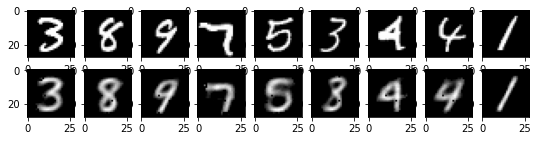

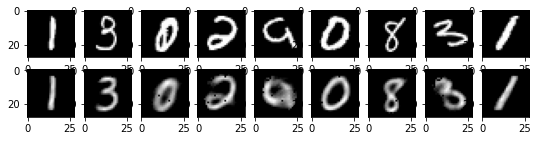

In [14]:
for k in range(2):
    plt.figure(figsize=(9, 2))
    img = outputs[k][1].squeeze(1).cuda().detach().cpu().clone().numpy()
    recon = outputs[k][2].squeeze(1).cuda().detach().cpu().clone().numpy()

    for i, item in enumerate(img):
        if i >= 9:
            break
        plt.subplot(2, 9, i+1)
        plt.imshow(item, cmap='gray')
    
    for i, item in enumerate(recon):
        if i >= 9: 
            break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item, cmap='gray') 